In [57]:
import numba
import numpy as np

import matplotlib.pyplot as plt

from fmm import Fmm

In [16]:
# Numba Threading Layer Configuration

## (Intel CPUs Only) Sets lifetime of OpenMP threads to 0ms
## As computation contains large serial (Python) components
! export KMP_BLOCKTIME=0

## Limit number of threads created by BLAS/LAPACK functions
## Called by Numpy
! export OMP_NUM_THREADS=1

## Define 'places' at which threads are assigned
! export OMP_PLACES=cores

## Makes thread assignment go succesively through available
## places. In our case, through each core.
! export OMP_PROC_BIND=close

## Select OpenMP as threading layer for Numba, the uniformity
## of FMM operators makes it preferable to TBB
! export NUMBA_THREADING_LAYER='omp'

In [27]:
# Generate test data (optional)
# ! fmm generate-test-data -c n_crit_150_p_6
# ! fmm compute-operators -c n_crit_150_p_6
# ! fmm generate-test-data -c n_crit_150_p_8
# ! fmm compute-operators -c n_crit_150_p_8
# ! fmm generate-test-data -c n_crit_150_p_10
# ! fmm compute-operators -c n_crit_150_p_10
# ! fmm generate-test-data -c n_crit_150_p_7
# ! fmm compute-operators -c n_crit_150_p_7
# ! fmm generate-test-data -c n_crit_150_p_9
# ! fmm compute-operators -c n_crit_150_p_9

Generating random sources & targets
Computing operators
Computing octree
Computing Inner Surface of Order 10
Computing Outer Surface of Order 10
Computing Inverse of Check To Equivalent Gram Matrix
Computing M2M & L2L Operators
Computed (1/8) M2M/L2L operators
Computed (2/8) M2M/L2L operators
Computed (3/8) M2M/L2L operators
Computed (4/8) M2M/L2L operators
Computed (5/8) M2M/L2L operators
Computed (6/8) M2M/L2L operators
Computed (7/8) M2M/L2L operators
Computed (8/8) M2M/L2L operators
Computed operators for (1/4) M2L Levels
Computed operators for (2/4) M2L Levels
Computed operators for (3/4) M2L Levels
Computed operators for (4/4) M2L Levels
Total time elapsed 0 minutes and 24 seconds


Generating random sources & targets
Computing operators
Computing octree
Computing Inner Surface of Order 7
Computing Outer Surface of Order 7
Computing Inverse of Check To Equivalent Gram Matrix
Computing M2M & L2L Operators
Computed (1/8) M2M/L2L operators
Computed (2/8) M2M/L2L operators
Computed (3/8) M2M/L2L operators
Computed (4/8) M2M/L2L operators
Computed (5/8) M2M/L2L operators
Computed (6/8) M2M/L2L operators
Computed (7/8) M2M/L2L operators
Computed (8/8) M2M/L2L operators
Computed operators for (1/4) M2L Levels
Computed operators for (2/4) M2L Levels
Computed operators for (3/4) M2L Levels
Computed operators for (4/4) M2L Levels
Total time elapsed 0 minutes and 14 seconds
Generating random sources & targets
Computing operators
Computing octree
Computing Inner Surface of Order 9
Computing Outer Surface of Order 9
Computing Inverse of Check To Equivalent Gram Matrix
Computing M2M & L2L Operators
Computed (1/8) M2M/L2L operators
Computed (2/8) M2M/L2L operators
Computed (3/8)

In [28]:
evec = [
    Fmm('n_crit_150_p_6', verbose=True),
    Fmm('n_crit_150_p_8', verbose=True),
    Fmm('n_crit_150_p_10', verbose=True),
]

In [50]:
evec2 = [
    Fmm('n_crit_150_p_7', verbose=True),
    Fmm('n_crit_150_p_9', verbose=True)
]

In [31]:
for e in evec:
    e.run()

P2M: 0.4213533401489258
M2M: 0.2624552249908447
L2L: 0.3525733947753906
M2L: 13.126320123672485
L2T: 0.39219188690185547
M2T: 0.006562948226928711
S2L: 0.4144322872161865
P2P: 0.3918323516845703
P2M: 0.812192440032959
M2M: 1.011019229888916
L2L: 1.1071057319641113
M2L: 32.277084827423096
L2T: 0.7334260940551758
M2T: 0.006470680236816406
S2L: 0.7785842418670654
P2P: 0.3899848461151123
P2M: 1.3407843112945557
M2M: 4.018711805343628
L2L: 4.463682413101196
M2L: 108.03561091423035
L2T: 1.1274476051330566
M2T: 0.006874561309814453
S2L: 1.250892162322998
P2P: 0.39708733558654785


In [51]:
for e in evec2:
    e.run()

P2M: 0.5867736339569092
M2M: 0.5348410606384277
L2L: 0.6505753993988037
M2L: 22.949918746948242
L2T: 0.5611567497253418
M2T: 0.006270885467529297
S2L: 0.5767309665679932
P2P: 0.39307165145874023
P2M: 1.0494475364685059
M2M: 1.6036531925201416
L2L: 1.8173432350158691
M2L: 47.429853677749634
L2T: 0.9384725093841553
M2T: 0.006260871887207031
S2L: 1.0079259872436523
P2P: 0.39661478996276855


# L2T Without Cache Local Optimizations

In [32]:
import adaptoctree.morton as morton

import fmm.kernel as kernel
import fmm.surface as surface

## L2T

In [33]:
@numba.njit(cache=True, parallel=True)
def u_l2t(
    leaves, 
    nleaves,
    targets,
    x0,
    r0,
    key_to_leaf_index,
    target_index_pointer,
    equivalent_surface,
    alpha_outer,
    key_to_index,
    nequivalent_points,
    local_expansions,
):
    
    for i in numba.prange(nleaves):
        target = leaves[i]
        level = morton.find_level(target)
        center = morton.find_physical_center_from_key(target, x0, r0)
        target_leaf_index = key_to_leaf_index[target]
        targets_at_node = targets[
            target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1]
        ]
        sources_at_node = surface.scale_surface(
            equivalent_surface,
            r0,
            level,
            center,
            alpha_outer,
        )
        source_idx = key_to_index[target]
        source_lidx = source_idx*nequivalent_points
        source_ridx = source_lidx+nequivalent_points
        source_densities_at_node = local_expansions[source_lidx:source_ridx]
        
        # Find potential
        kernel.laplace_p2p_serial(sources_at_node, targets_at_node, source_densities_at_node)
        
        # Find potential gradient
        kernel.laplace_gradient(sources_at_node, targets_at_node, source_densities_at_node)

In [36]:
%%timeit
i = 0
u_l2t(
    evec[i].leaves,
    evec[i].nleaves,
    evec[i].targets,
    evec[i].x0,
    evec[i].r0,
    evec[i].key_to_leaf_index,
    evec[i].target_index_pointer,
    evec[i].equivalent_surface,
    evec[i].alpha_outer,
    evec[i].key_to_index,
    evec[i].nequivalent_points,
    evec[i].local_expansions
)

416 ms ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
i = 1
u_l2t(
    evec[i].leaves,
    evec[i].nleaves,
    evec[i].targets,
    evec[i].x0,
    evec[i].r0,
    evec[i].key_to_leaf_index,
    evec[i].target_index_pointer,
    evec[i].equivalent_surface,
    evec[i].alpha_outer,
    evec[i].key_to_index,
    evec[i].nequivalent_points,
    evec[i].local_expansions
)

790 ms ± 7.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
i = 2
u_l2t(
    evec[i].leaves,
    evec[i].nleaves,
    evec[i].targets,
    evec[i].x0,
    evec[i].r0,
    evec[i].key_to_leaf_index,
    evec[i].target_index_pointer,
    evec[i].equivalent_surface,
    evec[i].alpha_outer,
    evec[i].key_to_index,
    evec[i].nequivalent_points,
    evec[i].local_expansions
)

1.27 s ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
cache_vec = np.array([ 0.39219188690185547, 0.7334260940551758, 1.1274476051330566])*1000
naive_vec = np.array([416, 790, 1270])

In [48]:
(naive_vec/cache_vec)

array([1.06070527, 1.07713648, 1.12643815])

In [46]:
for e in evec:
    print(e.nleaves)

32768
32768
32768


In [52]:
%%timeit
i = 0
u_l2t(
    evec2[i].leaves,
    evec2[i].nleaves,
    evec2[i].targets,
    evec2[i].x0,
    evec2[i].r0,
    evec2[i].key_to_leaf_index,
    evec2[i].target_index_pointer,
    evec2[i].equivalent_surface,
    evec2[i].alpha_outer,
    evec2[i].key_to_index,
    evec2[i].nequivalent_points,
    evec2[i].local_expansions
)

593 ms ± 9.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%%timeit
i = 1
u_l2t(
    evec2[i].leaves,
    evec2[i].nleaves,
    evec2[i].targets,
    evec2[i].x0,
    evec2[i].r0,
    evec2[i].key_to_leaf_index,
    evec2[i].target_index_pointer,
    evec2[i].equivalent_surface,
    evec2[i].alpha_outer,
    evec2[i].key_to_index,
    evec2[i].nequivalent_points,
    evec2[i].local_expansions
)

1.02 s ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
593/561

1.0570409982174689

In [55]:
1020/938

1.0874200426439233

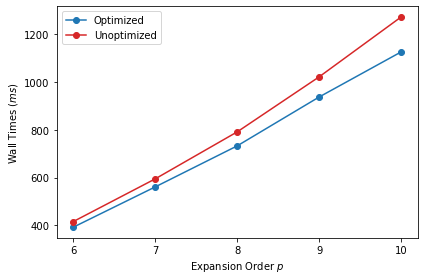

In [81]:
pvec = [6, 7, 8, 9, 10]
runtimes = [392, 561, 733, 938, 1127]

speedup = [1.06, 1.06, 1.08, 1.09, 1.13]
runtimes2 = np.array(runtimes)*np.array(speedup)

fig, ax = plt.subplots()

ax.plot(pvec, runtimes, '-o', color='tab:blue', label='Optimized')
ax.set_xticks(pvec)
ax.set_xticklabels(pvec)
ax.set_ylabel('Wall Times ($ms$)')
ax.set_xlabel('Expansion Order $p$')

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# 
# color = 'tab:red'
# ax2.set_ylabel('Ratio of Wall Time to 1000x1000 Matmul (%)')  # we already handled the x-label with ax1
# ax.set_ylabel('Unoptimized Times', color='tab:red')
ax.plot(pvec, runtimes2, '-o', color='tab:red', label='Unoptimized')
ax.tick_params(axis='y',)

ax.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('speedup.png', dpi=300)

In [76]:
runtimes2

array([ 415.52,  594.66,  791.64, 1022.42, 1273.51])